<a href="https://colab.research.google.com/github/ChamodKalupahana/simulating_the_universe_using_GANs/blob/main/Conditional_Residual_U_net_and_Vanilla_U_net_for_N_body_to_hydro_to_generate_unshuffled_evaluation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chamod's Vanilla U-net model for N-body to M_Z (Unshuffled data)

using Adam's U-net

### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow_datasets as tfds
from keras import backend as K
from tensorflow.keras import models, layers, regularizers

N_body_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
hydro_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy' # REMEMBER TO CHECK SAVE FLIE PATH

Mounted at /content/drive


### Hyperparameters

In [ ]:
batch_size = 4
image_size = 256
num_of_epochs = 2

### Define data


In [ ]:
def input_N_body_and_M_Z_IllustrisTNG_data_without_labels():

  global N_body_field_file_path_IllustrisTNG, N_body_field_file_path_SIMBA, hydro_field_file_path_IllustrisTNG, hydro_field_file_path_SIMBA
  # ignore labels for now
  # asinh mean of N_Body_IllustrisTNG dataset = 26.00409
  N_body_dataset = np.arcsinh(np.load(N_body_field_file_path_IllustrisTNG))
  N_body_dataset = np.expand_dims((N_body_dataset) - np.mean(N_body_dataset), axis=3)

  # N_body_dataset_SIMBA = np.arcsinh(np.load(N_body_field_file_path_SIMBA))
  # N_body_dataset_SIMBA = np.expand_dims((N_body_dataset_SIMBA) - np.mean(N_body_dataset_SIMBA), axis=3)

  # N_body_dataset = np.append(N_body_dataset, N_body_dataset_SIMBA, axis=0)

  # np.log10 mean of M_Z_IllustrisTNG dataset = -6.6740975 (np.log10 produces correct lookings maps like in CAMELS examples)
  M_Z_dataset = np.log10(np.load(hydro_field_file_path_IllustrisTNG))
  M_Z_dataset = np.expand_dims((M_Z_dataset) - np.mean(M_Z_dataset), axis=3)

  # M_Z_dataset_SIMBA = np.log10(np.load(hydro_field_file_path_SIMBA))
  # M_Z_dataset_SIMBA = np.expand_dims((M_Z_dataset_SIMBA) - np.mean(M_Z_dataset_SIMBA), axis=3)

  # M_Z_dataset = np.append(M_Z_dataset, M_Z_dataset_SIMBA, axis=0)
  
  #10.089378 for full N-body dataset
  N_body_dataset = N_body_dataset / (np.max(np.abs(N_body_dataset))) # so that pixels are in range [-1,1]
  M_Z_dataset = M_Z_dataset / (np.max(np.abs(M_Z_dataset)))

  full_dataset = tf.data.Dataset.from_tensor_slices((N_body_dataset, M_Z_dataset))

  return full_dataset

ds = input_N_body_and_M_Z_IllustrisTNG_data_without_labels()

In [ ]:
def preprocess_image(train_image, truth_image):
    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    train_image = tf.image.resize(train_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    train_image = train_image - tf.keras.backend.min(train_image)
    train_image = train_image / tf.keras.backend.max(train_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    truth_image = tf.image.resize(truth_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    truth_image = truth_image - tf.keras.backend.min(truth_image)
    truth_image = truth_image / tf.keras.backend.max(truth_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    return train_image, truth_image 

x_train = (
    ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    #.shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

(4, 256, 256, 1)


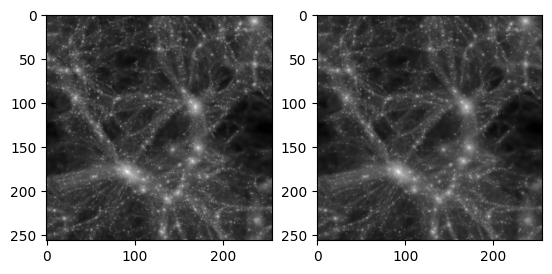

In [ ]:
# check training data
test = tfds.as_numpy(x_train)
test = iter(test)
train_batch, truth_batch = next(test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_batch[0], cmap='gray')
ax[1].imshow(truth_batch[0], cmap='gray')
print(np.shape(truth_batch))

# free up memory
del ds, test

### Vanilla Residual U-net

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, padding="same")(x)
    #outputs = x

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
# network architecture
image_size = 256
widths = [32, 64, 96, 128] # sizes to downsample to (in reverse)

model =  get_model((256,256),1)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Optimiser, adaptive LR scheduler, EarlyStopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
opt = tf.keras.optimizers.experimental.AdamW(weight_decay=0.001, learning_rate=1e-4) # try beta_1 = 0.5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, start_from_epoch=20, restore_best_weights=True, verbose=1)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

checkpoint_path = "256_training_copy/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=2,
                                                 save_best_only=True)

### Training

In [ ]:
# trained for 3 epochs
tf.keras.backend.clear_session()
history = model.fit(x_train, batch_size=4, # use 4 batch size for standard gpu for cham-net
                    epochs=num_of_epochs)

# callbacks=[early_stopping, reduce_lr, cp_callback]

Epoch 1/2
3750/3750 [==============================] - 198s 46ms/step - loss: 0.0977 - mae: 0.1500
Epoch 2/2
3750/3750 [==============================] - 177s 47ms/step - loss: 0.0055 - mae: 0.0530


### Test model

1/1 [==============================] - 0s 478ms/step


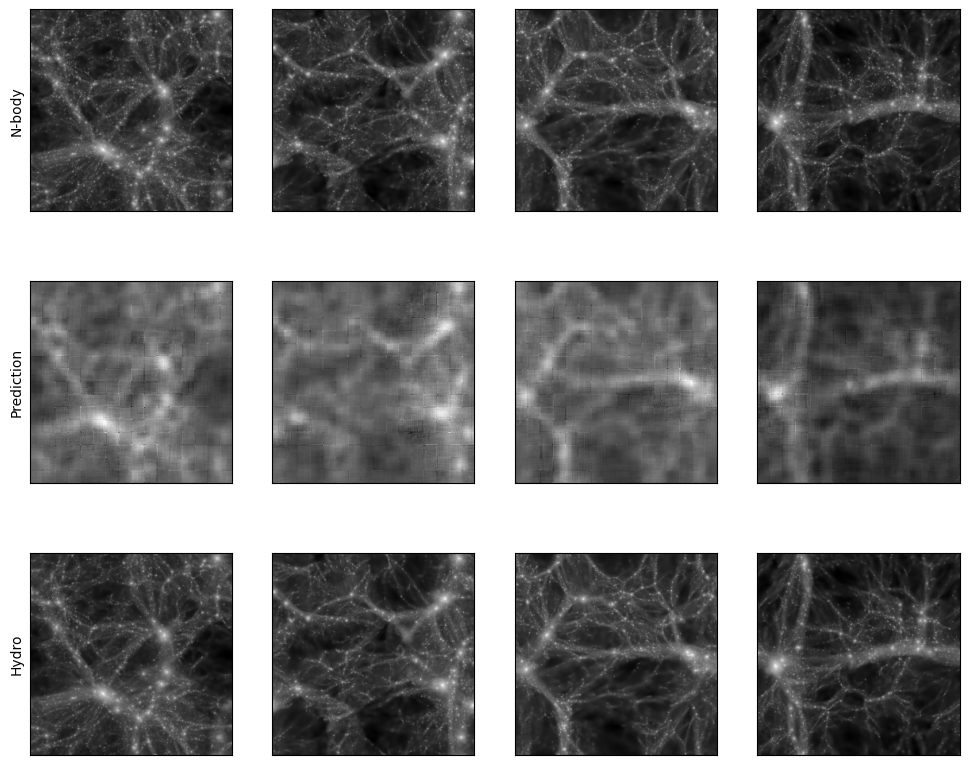

In [ ]:
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)


N = np.shape(test_batch)[0]
if batch_size > 4:
  N = 4

num_of_images_for_generate = batch_size
generated_images = model.predict(test_batch)


rows = 3
columns = 4
fig, ax = plt.subplots(rows,columns, figsize=(12, 10))
#fig.tight_layout()
#ax[row, column]

for column in range(columns):
    ax[0, column].imshow(test_batch[column], cmap='gray')
    ax[1, column].imshow(generated_images[column], cmap='gray')
    ax[2, column].imshow(truth_batch[column], cmap='gray')

    ax[0, 0].set_ylabel('N-body')
    ax[1, 0].set_ylabel('Prediction')
    ax[2, 0].set_ylabel('Hydro')
    for row in range(rows):
      #ax[row, column].axis("off")
      ax[row, column].set_xticks([])
      ax[row, column].set_yticks([])

### Save images

In [ ]:
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

num_of_saved_images = 1000 # must be mutiple of 4 (batch_size)
total_N_body_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_prediction_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_hydro_maps = np.zeros([num_of_saved_images, 256, 256, 1])

for index in range(4, num_of_saved_images, 4):
  generated_images = model.predict(test_batch)

  # save images in arrays
  total_N_body_maps[index-4:index, :,:,:] = test_batch
  total_prediction_maps[index-4:index, :,:,:] = generated_images
  total_hydro_maps[index-4:index, :,:,:] = truth_batch

  test_batch, truth_batch = next(test)


1/1 [==============================] - 0s 23ms/step


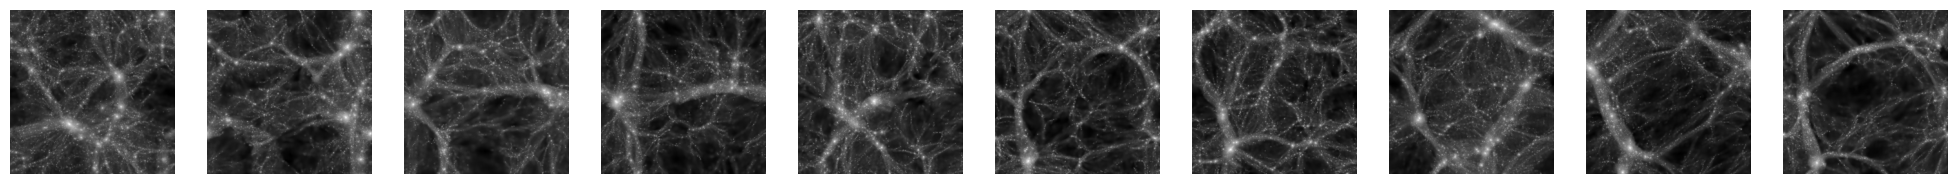

In [ ]:
# n-body graphs should match
columns = 10

fig, ax = plt.subplots(1, columns, figsize=(25, 5))

for column in range(columns):
  ax[column].imshow(total_N_body_maps[column], cmap='gray')
  ax[column].axis('off')

In [ ]:
#np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/N_body_1000_images', total_N_body_maps)
np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/vanilla_u_net_IllustrisTNG_2_epochs_M_tot_predictions_1000_images', total_prediction_maps)
#np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_tot_1000_images', total_hydro_maps)

### Calculate MSE

In [ ]:
num_of_saved_images = 1000 # for 15000 images with batch_size 4, takes around 1hr, num_of_batches = 3749
total_prediction_error = np.array([])

# reset iterator
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

for index in range(num_of_saved_images):
  generated_images = model.predict(test_batch)

  prediction_error = np.sum((generated_images - truth_batch)**2) / 65536
  total_prediction_error = np.append(total_prediction_error, prediction_error)

  test_batch, truth_batch = next(test)

total_prediction_error_mean = np.mean(total_prediction_error)
print('MSE per pixel between prediction and M_Z maps: {total_error:.4f}'.format(total_error = total_prediction_error_mean))
print(np.shape(total_prediction_error))

# pre-computed
# print('MAE per pixel between x_test and M_Z Maps: 1.8839')

1/1 [==============================] - 0s 20ms/step
MSE per pixel between prediction and M_Z maps: 0.0152
(1000,)


In [ ]:
map_number_array = np.arange(0, np.shape(predictions)[0])
plt.plot(map_number_array,total_error_array, 'b.')

best_line = np.zeros(np.shape(predictions)[0])
plt.plot(map_number_array, best_line,'k-')
plt.grid()
plt.title('Performance Evaluation of N_body to M_Z')
plt.ylabel('MAE')
plt.xlabel('Map Number')

In [ ]:
test_number = 0 # highest is 3749
cmap = 'gray'
#cmap = 'magma' # for simulation looking effect

# plotting infomation
fig, ax = plt.subplots(1, 3, figsize=(12, 20))

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Input')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Prediction')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Ground Truth')

ax[0].imshow(x_test[test_number], cmap)
ax[1].imshow(predictions[test_number], cmap)
ax[2].imshow(y_test[test_number], cmap)

plt.show()

### Plot best image

In [ ]:
index = np.where(np.min(total_error_array) == total_error_array)[0][0]
# plotting infomation
fig, ax = plt.subplots(1, 3, figsize=(12, 20))
cmap = 'gray'

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Input')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Prediction')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Ground Truth')

ax[0].imshow(x_test[index], cmap)
ax[1].imshow(predictions[index], cmap)
ax[2].imshow(y_test[index], cmap)

print('MAE Error',total_error_array[index],)

In [ ]:
print(1/0) # to stop colab running the next section

# Chamod's Residual U-net model for N-body to M_Z (Unshuffled data)

by adapting https://keras.io/examples/generative/ddim/#denoising-diffusion-implicit-models to remove time embeddings

### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow_datasets as tfds
from keras import backend as K
from tensorflow.keras import models, layers, regularizers

N_body_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
hydro_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy' # REMEMBER TO CHECK SAVE FLIE PATH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyperparameters

In [ ]:
batch_size = 4
image_size = 256
num_of_epochs = 2

### Define data


In [ ]:
def input_N_body_and_M_Z_IllustrisTNG_data_without_labels():

  global N_body_field_file_path_IllustrisTNG, N_body_field_file_path_SIMBA, hydro_field_file_path_IllustrisTNG, hydro_field_file_path_SIMBA
  # ignore labels for now
  # asinh mean of N_Body_IllustrisTNG dataset = 26.00409
  N_body_dataset = np.arcsinh(np.load(N_body_field_file_path_IllustrisTNG))
  N_body_dataset = np.expand_dims((N_body_dataset) - np.mean(N_body_dataset), axis=3)

  # N_body_dataset_SIMBA = np.arcsinh(np.load(N_body_field_file_path_SIMBA))
  # N_body_dataset_SIMBA = np.expand_dims((N_body_dataset_SIMBA) - np.mean(N_body_dataset_SIMBA), axis=3)

  # N_body_dataset = np.append(N_body_dataset, N_body_dataset_SIMBA, axis=0)

  # np.log10 mean of M_Z_IllustrisTNG dataset = -6.6740975 (np.log10 produces correct lookings maps like in CAMELS examples)
  M_Z_dataset = np.log10(np.load(hydro_field_file_path_IllustrisTNG))
  M_Z_dataset = np.expand_dims((M_Z_dataset) - np.mean(M_Z_dataset), axis=3)

  # M_Z_dataset_SIMBA = np.log10(np.load(hydro_field_file_path_SIMBA))
  # M_Z_dataset_SIMBA = np.expand_dims((M_Z_dataset_SIMBA) - np.mean(M_Z_dataset_SIMBA), axis=3)

  # M_Z_dataset = np.append(M_Z_dataset, M_Z_dataset_SIMBA, axis=0)
  
  #10.089378 for full N-body dataset
  N_body_dataset = N_body_dataset / (np.max(np.abs(N_body_dataset))) # so that pixels are in range [-1,1]
  M_Z_dataset = M_Z_dataset / (np.max(np.abs(M_Z_dataset)))

  full_dataset = tf.data.Dataset.from_tensor_slices((N_body_dataset, M_Z_dataset))

  return full_dataset

ds = input_N_body_and_M_Z_IllustrisTNG_data_without_labels()

In [ ]:
def preprocess_image(train_image, truth_image):
    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    train_image = tf.image.resize(train_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    train_image = train_image - tf.keras.backend.min(train_image)
    train_image = train_image / tf.keras.backend.max(train_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    truth_image = tf.image.resize(truth_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    truth_image = truth_image - tf.keras.backend.min(truth_image)
    truth_image = truth_image / tf.keras.backend.max(truth_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    return train_image, truth_image 

x_train = (
    ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    #.shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

(4, 256, 256, 1)


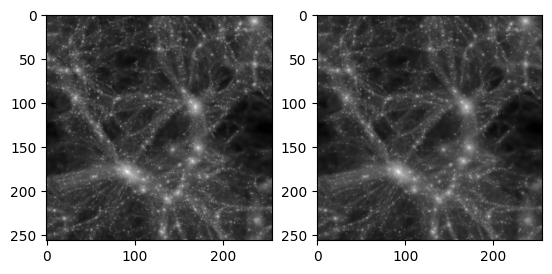

In [ ]:
# check training data
test = tfds.as_numpy(x_train)
test = iter(test)
train_batch, truth_batch = next(test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_batch[0], cmap='gray')
ax[1].imshow(truth_batch[0], cmap='gray')
print(np.shape(truth_batch))

# free up memory
del ds, test

### Define Attention Residual U-net

In [ ]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply
  
def get_residual_unet(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 1)) # changed channels from 3 to 1
    
    # remove time embeddings
    #noise_variances = keras.Input(shape=(1, 1, 1))
    #e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    #e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    #x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x) # changed filters from 3 to 1 (for 1 channel output)

    return keras.Model([noisy_images], x, name="residual_unet") # removed nosie variance for no time embeddings

In [ ]:
# network architecture
image_size = 256
widths = [32, 64, 96, 128] # sizes to downsample to (in reverse)
block_depth = 2

model = get_residual_unet(image_size, widths, block_depth)

In [ ]:
model.summary()

Model: "residual_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  64          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  64         ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
# Optimiser, adaptive LR scheduler, EarlyStopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
opt = tf.keras.optimizers.experimental.AdamW(weight_decay=0.001, learning_rate=1e-4) # try beta_1 = 0.5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, start_from_epoch=20, restore_best_weights=True, verbose=1)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

checkpoint_path = "256_training_copy/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=2,
                                                 save_best_only=True)

### Training

In [ ]:
# trained for 3 epochs
tf.keras.backend.clear_session()
history = model.fit(x_train, batch_size=4, # use 4 batch size for standard gpu for cham-net
                    epochs=num_of_epochs)

# callbacks=[early_stopping, reduce_lr, cp_callback]

Epoch 1/2
3750/3750 [==============================] - 697s 180ms/step - loss: 6.9896e-04 - mae: 0.0172
Epoch 2/2
3750/3750 [==============================] - 677s 180ms/step - loss: 4.6573e-04 - mae: 0.0150


### Test model

1/1 [==============================] - 1s 578ms/step


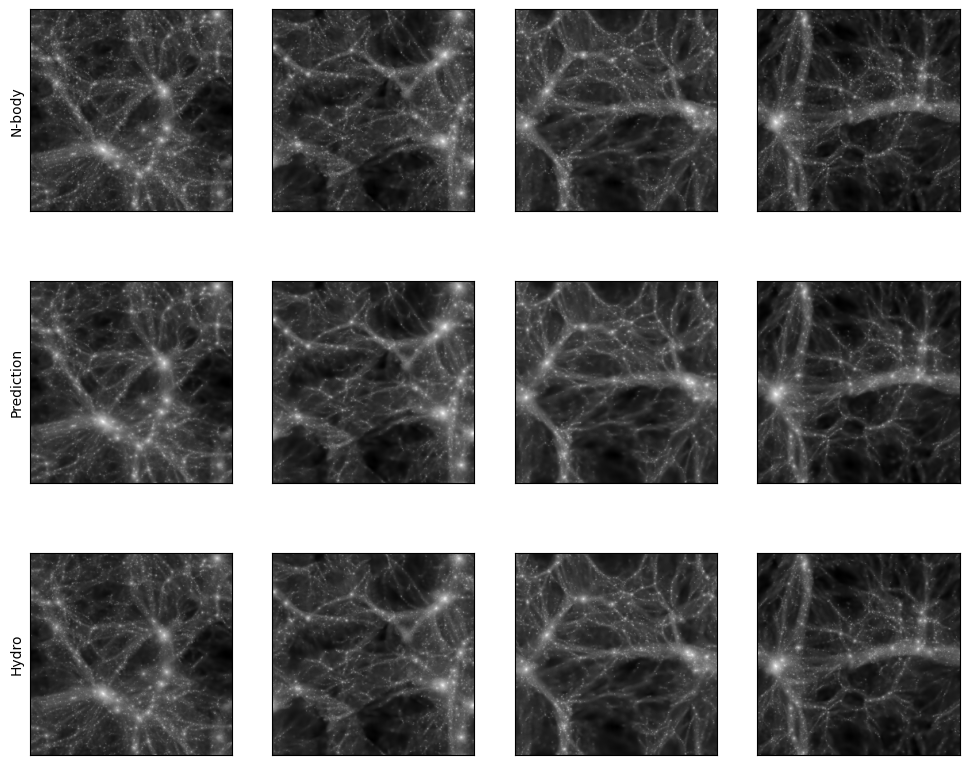

In [ ]:
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)


N = np.shape(test_batch)[0]
if batch_size > 4:
  N = 4

num_of_images_for_generate = batch_size
generated_images = model.predict(test_batch)


rows = 3
columns = 4
fig, ax = plt.subplots(rows,columns, figsize=(12, 10))
#fig.tight_layout()
#ax[row, column]

for column in range(columns):
    ax[0, column].imshow(test_batch[column], cmap='gray')
    ax[1, column].imshow(generated_images[column], cmap='gray')
    ax[2, column].imshow(truth_batch[column], cmap='gray')

    ax[0, 0].set_ylabel('N-body')
    ax[1, 0].set_ylabel('Prediction')
    ax[2, 0].set_ylabel('Hydro')
    for row in range(rows):
      #ax[row, column].axis("off")
      ax[row, column].set_xticks([])
      ax[row, column].set_yticks([])

### Save images

In [ ]:
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

num_of_saved_images = 1000 # must be mutiple of 4 (batch_size)
total_N_body_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_prediction_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_hydro_maps = np.zeros([num_of_saved_images, 256, 256, 1])

for index in range(4, num_of_saved_images, 4):
  generated_images = model.predict(test_batch)

  # save images in arrays
  total_N_body_maps[index-4:index, :,:,:] = test_batch
  total_prediction_maps[index-4:index, :,:,:] = generated_images
  total_hydro_maps[index-4:index, :,:,:] = truth_batch

  test_batch, truth_batch = next(test)


1/1 [==============================] - 0s 23ms/step


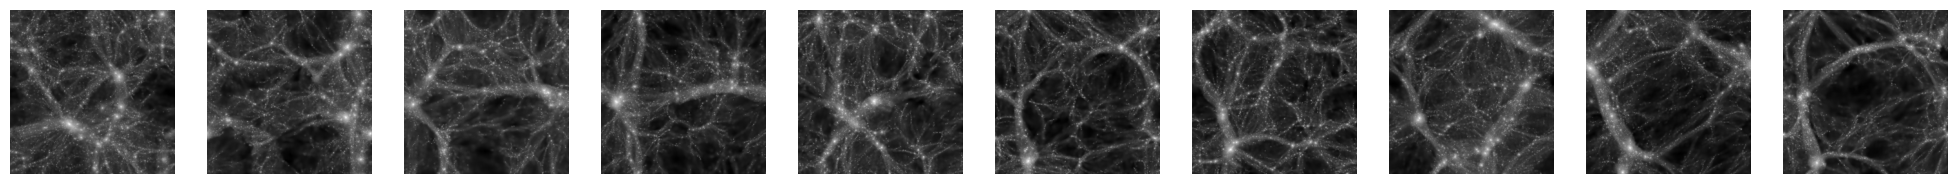

In [ ]:
# n-body graphs should match
columns = 10

fig, ax = plt.subplots(1, columns, figsize=(25, 5))

for column in range(columns):
  ax[column].imshow(total_N_body_maps[column], cmap='gray')
  ax[column].axis('off')

In [ ]:
#np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/N_body_1000_images', total_N_body_maps)
np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/resdiual_u_net_IllustrisTNG_2_epochs_M_tot_predictions_1000_images', total_prediction_maps)
#np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_tot_1000_images', total_hydro_maps)

### Calculate MSE

In [ ]:
num_of_saved_images = 1000 # for 15000 images with batch_size 4, takes around 1hr, num_of_batches = 3749
total_prediction_error = np.array([])

# reset iterator
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

for index in range(num_of_saved_images):
  generated_images = model.predict(test_batch)

  prediction_error = np.sum((generated_images - truth_batch)**2) / 65536
  total_prediction_error = np.append(total_prediction_error, prediction_error)

  test_batch, truth_batch = next(test)

total_prediction_error_mean = np.mean(total_prediction_error)
print('MSE per pixel between prediction and M_Z maps: {total_error:.4f}'.format(total_error = total_prediction_error_mean))
print(np.shape(total_prediction_error))

# pre-computed
# print('MAE per pixel between x_test and M_Z Maps: 1.8839')

1/1 [==============================] - 0s 22ms/step
MSE per pixel between prediction and M_Z maps: 0.0016
(1000,)


In [ ]:
map_number_array = np.arange(0, np.shape(predictions)[0])
plt.plot(map_number_array,total_error_array, 'b.')

best_line = np.zeros(np.shape(predictions)[0])
plt.plot(map_number_array, best_line,'k-')
plt.grid()
plt.title('Performance Evaluation of N_body to M_Z')
plt.ylabel('MAE')
plt.xlabel('Map Number')

In [ ]:
test_number = 0 # highest is 3749
cmap = 'gray'
#cmap = 'magma' # for simulation looking effect

# plotting infomation
fig, ax = plt.subplots(1, 3, figsize=(12, 20))

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Input')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Prediction')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Ground Truth')

ax[0].imshow(x_test[test_number], cmap)
ax[1].imshow(predictions[test_number], cmap)
ax[2].imshow(y_test[test_number], cmap)

plt.show()

### Plot best image

In [ ]:
index = np.where(np.min(total_error_array) == total_error_array)[0][0]
# plotting infomation
fig, ax = plt.subplots(1, 3, figsize=(12, 20))
cmap = 'gray'

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Input')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Prediction')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Ground Truth')

ax[0].imshow(x_test[index], cmap)
ax[1].imshow(predictions[index], cmap)
ax[2].imshow(y_test[index], cmap)

print('MAE Error',total_error_array[index],)

In [ ]:
print(1/0) # to stop colab running the next section